# 某闯关类手游用户流失预测

## 1.案例简介

在当代的娱乐领域，手游已稳居重要地位，成为人们释放压力，享受休闲的主要方式。近几年，各式各样的手游层出不穷，其中，以闯关式休闲手游因其能充分利用零散时间而深得市场喜爱。然而，新用户流失的问题在这些游戏中依然严重，大量新用户在试玩不久后就选择放弃。如果能在用户彻底卸载游戏之前对可能流失的用户进行有效干预，比如赠送游戏道具或发送鼓励的消息，就有可能挽留住他们，进而提升游戏的活跃度和公司的潜在利润。因此，预测用户流失已经成为一个极具挑战性的重要问题。在我们的毕业项目中，我们将以真实游戏的非结构化日志数据为出发点，构建一个用户流失预测模型，并根据已有知识设计合适的算法来解决实际问题。

### 文件1：train.csv  训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。

In [10]:
import pandas as pd

train_df = pd.read_csv('./data/train.csv', sep='\t')
train_df.T
print(train_df.head())
print("------------------------------------")
print(train_df['label'].value_counts())

   user_id  label
0     2774      0
1     2775      0
2     2776      1
3     2777      0
4     2778      1
------------------------------------
0    5428
1    2730
Name: label, dtype: int64


### 文件2：dev.csv 验证集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。

In [11]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T
print(dev_df.head())
print("------------------------------------")
print(dev_df['label'].value_counts())

   user_id  label
0    10932      0
1    10933      1
2    10934      0
3    10935      1
4    10936      0
------------------------------------
0    1757
1     901
Name: label, dtype: int64


### 文件3：test.csv 测试集用户，只包含用户 id，任务就是要预测这些用户的流失概率。

In [12]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T
print(test_df.head())
print("------------------------------------")
print(len(test_df))

   user_id
0        1
1        2
2        3
3        4
4        5
------------------------------------
2773


### 文件5：level_seq.csv. 核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与游戏限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

In [13]:
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


### 文件6：level_meta.csv. 每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [14]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508



---
---
# <center>答案区</center>

## 1 数据预处理
从以下几个维度进行特征工程，刻画不同用户：
- 是否喜欢：
    - `day`：登录天数。
    - `login`：登录次数。 
    - `time`：游戏总花费的时间
    - `try`：尝试记录次数
- 游玩体验：
    - `success`：通关数/尝试次数
    - `maxlevel`：最大闯关数
    - `maxwin`：最大连赢数 
    - `maxfail`：最大连输数
    - `winof20`：最后20局的胜率  
- 个人特性：
    - `beginday`：开始玩的时间 
    - `help`：使用帮助的频率 
    - `retry`：最大愿意重试的次数
    - `duration`：平均每一关超出平均时长
    - `restep`：成功通关的记录中，平均剩余步数与限定步数之比







In [15]:
from datetime import datetime

# 定义一个函数，将日期时间字符串转换为 datetime 对象
def cvttime(data):
    date, time = str(data).split()  # 先将日期和时间分开
    year, month, day = map(int, date.split('-'))  # 将日期字符串转换为年月日三个整数
    hour, minute, second = map(int, time.split(':'))  # 将时间字符串转换为时分秒三个整数
    return datetime(year, month, day, hour, minute, second)  # 返回 datetime 对象

# 获取日期时间对象的各个部分
seq_df['day'] = seq_df['time'].map(lambda x: int(x.split(' ')[0].split('-')[2]))

# 使用 map() 函数将日期时间字符串转换为 datetime 对象
seq_df['time'] = seq_df['time'].map(lambda x: cvttime(x))

# 平均每次尝试花费的时间
f_avg = meta_df['f_avg_duration'].values

# 游戏平均时长
seq_df['exc_time'] = seq_df.apply(lambda x: x['f_duration']-f_avg[int(x['level_id']-1)], axis = 1)

# 输出 DataFrame 的前几行，检查结果是否正确
print(seq_df.head())

   user_id  level_id  f_success  f_duration  f_reststep  f_help  \
0    10932         1          1       127.0    0.500000       0   
1    10932         2          1        69.0    0.703704       0   
2    10932         3          1        67.0    0.560000       0   
3    10932         4          1        58.0    0.700000       0   
4    10932         5          1        83.0    0.666667       0   

                 time  day   exc_time  
0 2020-02-01 00:05:51    1  87.110060  
1 2020-02-01 00:08:01    1   8.316025  
2 2020-02-01 00:09:50    1  -9.947355  
3 2020-02-01 00:11:16    1  -0.170347  
4 2020-02-01 00:13:12    1 -18.784577  


In [16]:
def cal_login(series):
    # 计算用户登录天数
    ans = 1
    for start, end in zip(*[iter(series)]*2):
        # 如果两次登录时间间隔超过 15 分钟，则认为是两次不同的登录
        if (end - start).total_seconds() > 900:
            ans += 1
    return ans

def cal_fail_retry(df):
    # 计算连续失败的最大次数
    fail_series = df['f_success'].eq(0)  # 将 f_success 列中的值为 0 的元素设为 True，其余元素设为 False
    fail_counts = fail_series.groupby((fail_series != fail_series.shift()).cumsum()).cumsum()  # 计算连续的 True 的个数
    max_fail = fail_counts.max()  # 取连续的 True 的个数的最大值

    # 计算连续成功的最大次数
    win_series = df['f_success'].eq(1)  # 将 f_success 列中的值为 1 的元素设为 True，其余元素设为 False
    win_counts = win_series.groupby((win_series != win_series.shift()).cumsum()).cumsum()  # 计算连续的 True 的个数
    max_win = win_counts.max()  # 取连续的 True 的个数的最大值

    # 计算连续重试的最大次数
    retry_series = df['level_id']  # 获取 level_id 列
    retry_counts = retry_series.groupby((retry_series != retry_series.shift()).cumsum()).cumcount()  # 计算连续的相同元素的个数
    max_retry = retry_counts.max()  # 取连续的相同元素的个数的最大值

    return max_win, max_fail, max_retry

In [17]:
import numpy as np 
from tqdm import tqdm

# 按照 user_id 进行分组
user_df = seq_df.groupby('user_id')
 
# 初始化训练集、验证集和测试集的 X 和 y
train_X, valid_X, test_X = [], [], []
train_y, valid_y, test_y = [], [], []

# 遍历每个用户的 DataFrame
for userid, df in tqdm(user_df):
    user = []

    # 是否喜欢
    user.append(len(set(df['day'])))  # 统计用户登录天数
    login = cal_login(df['time'])  # 计算用户登录次数
    user.append(login) 
    user.append(sum(df['f_duration']))  # 统计用户总游戏时长
    try_ = df.shape[0]  # 统计用户总尝试次数

    # 游戏体验
    user.append(try_)
    user.append(np.nanmean(df['f_success']))  # 统计用户平均成功率
    user.append(max(df['level_id']))  # 统计用户最高关卡 ID
    win, fail, retry = cal_fail_retry(df)  # 计算用户最大连胜次数、最大连败次数和最大连续重试次数
    user.append(win)
    user.append(fail)
    user.append(np.nanmean(df['f_success'][-20 if try_>20 else 0:]))  # 统计用户最近 20 次游戏的平均成功率  

    # 个人特性
    user.append(min(df['day']))  # 统计用户第一次登录的日期
    user.append(np.nanmean(df['f_help']))  # 统计用户平均求助次数 
    user.append(retry) # 统计用户最大连续重试次数
    user.append(np.nanmean(df['exc_time']))  # 统计用户平均游戏时长
    # 统计用户最近 20 次游戏的平均游戏时长
    if not df[df['f_success'] == 1].shape[0]:  # 如果用户没有成功过
        user.append(0)
    else:
        user.append(np.nanmean(df[df['f_success'] == 1]['f_reststep']))  # 统计用户成功时的平均剩余步数

    # 将用户特征添加到对应的集合中
    if userid in set(train_df['user_id']):  # 如果用户在训练集中
        train_X.append(user)
        train_y.append(train_df[train_df['user_id'] == userid]['label'])
    elif userid in set(dev_df['user_id']):  # 如果用户在验证集中
        valid_X.append(user)
        valid_y.append(dev_df[dev_df['user_id'] == userid]['label'])
    else:  # 如果用户在测试集中
        test_X.append(user)

100%|██████████| 13589/13589 [00:26<00:00, 517.59it/s]


In [18]:
train_X, valid_X, test_X = np.array(train_X), np.array(valid_X), np.array(test_X)
train_y, valid_y, test_y = np.array(train_y), np.array(valid_y), np.array(test_y)
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

feature_df = pd.DataFrame(np.concatenate((train_X, train_y),axis =1), columns=['day', 'login',  'time', 'try', 'success', 'maxlevel', 'maxwin', 'maxfail', 'winof20', 'beginday', 'help', 'retry', 'duration', 'restep', 'label'])
feature_df.describe()


(8158, 14) (8158, 1)
(2658, 14) (2658, 1)
(2773, 14) (0,)


,day,login,time,try,success,maxlevel,maxwin,maxfail,winof20,beginday,help,retry,duration,restep,label
count,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.00000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000
mean,3.178475,5.455994,17479.688772,161.776538,0.673581,129.745894,20.357195,7.17443,0.528459,1.015200,0.044279,7.366144,-103.787820,0.322834,0.334641
std,0.848463,4.109535,19474.149335,184.456500,0.192768,113.298225,28.268813,11.03897,0.269326,0.139226,0.040586,12.865756,108.102283,0.091907,0.471894
min,2.000000,1.000000,22.000000,2.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,-822.308533,0.000000,0.000000
25%,2.000000,2.000000,4332.000000,44.000000,0.528976,39.000000,12.000000,2.00000,0.300000,1.000000,0.013699,2.000000,-145.989994,0.253997,0.000000
50%,3.000000,4.000000,11737.500000,107.000000,0.680000,122.000000,17.000000,5.00000,0.500000,1.000000,0.038710,5.000000,-72.764288,0.300037,0.000000
75%,4.000000,7.000000,24300.250000,211.000000,0.827586,178.000000,24.000000,9.00000,0.750000,1.000000,0.065273,9.000000,-27.431674,0.375638,1.000000
max,4.000000,31.000000,534421.000000,4122.000000,1.000000,1509.000000,1675.000000,394.00000,1.000000,3.000000,0.796875,426.000000,342.713043,0.777778,1.000000


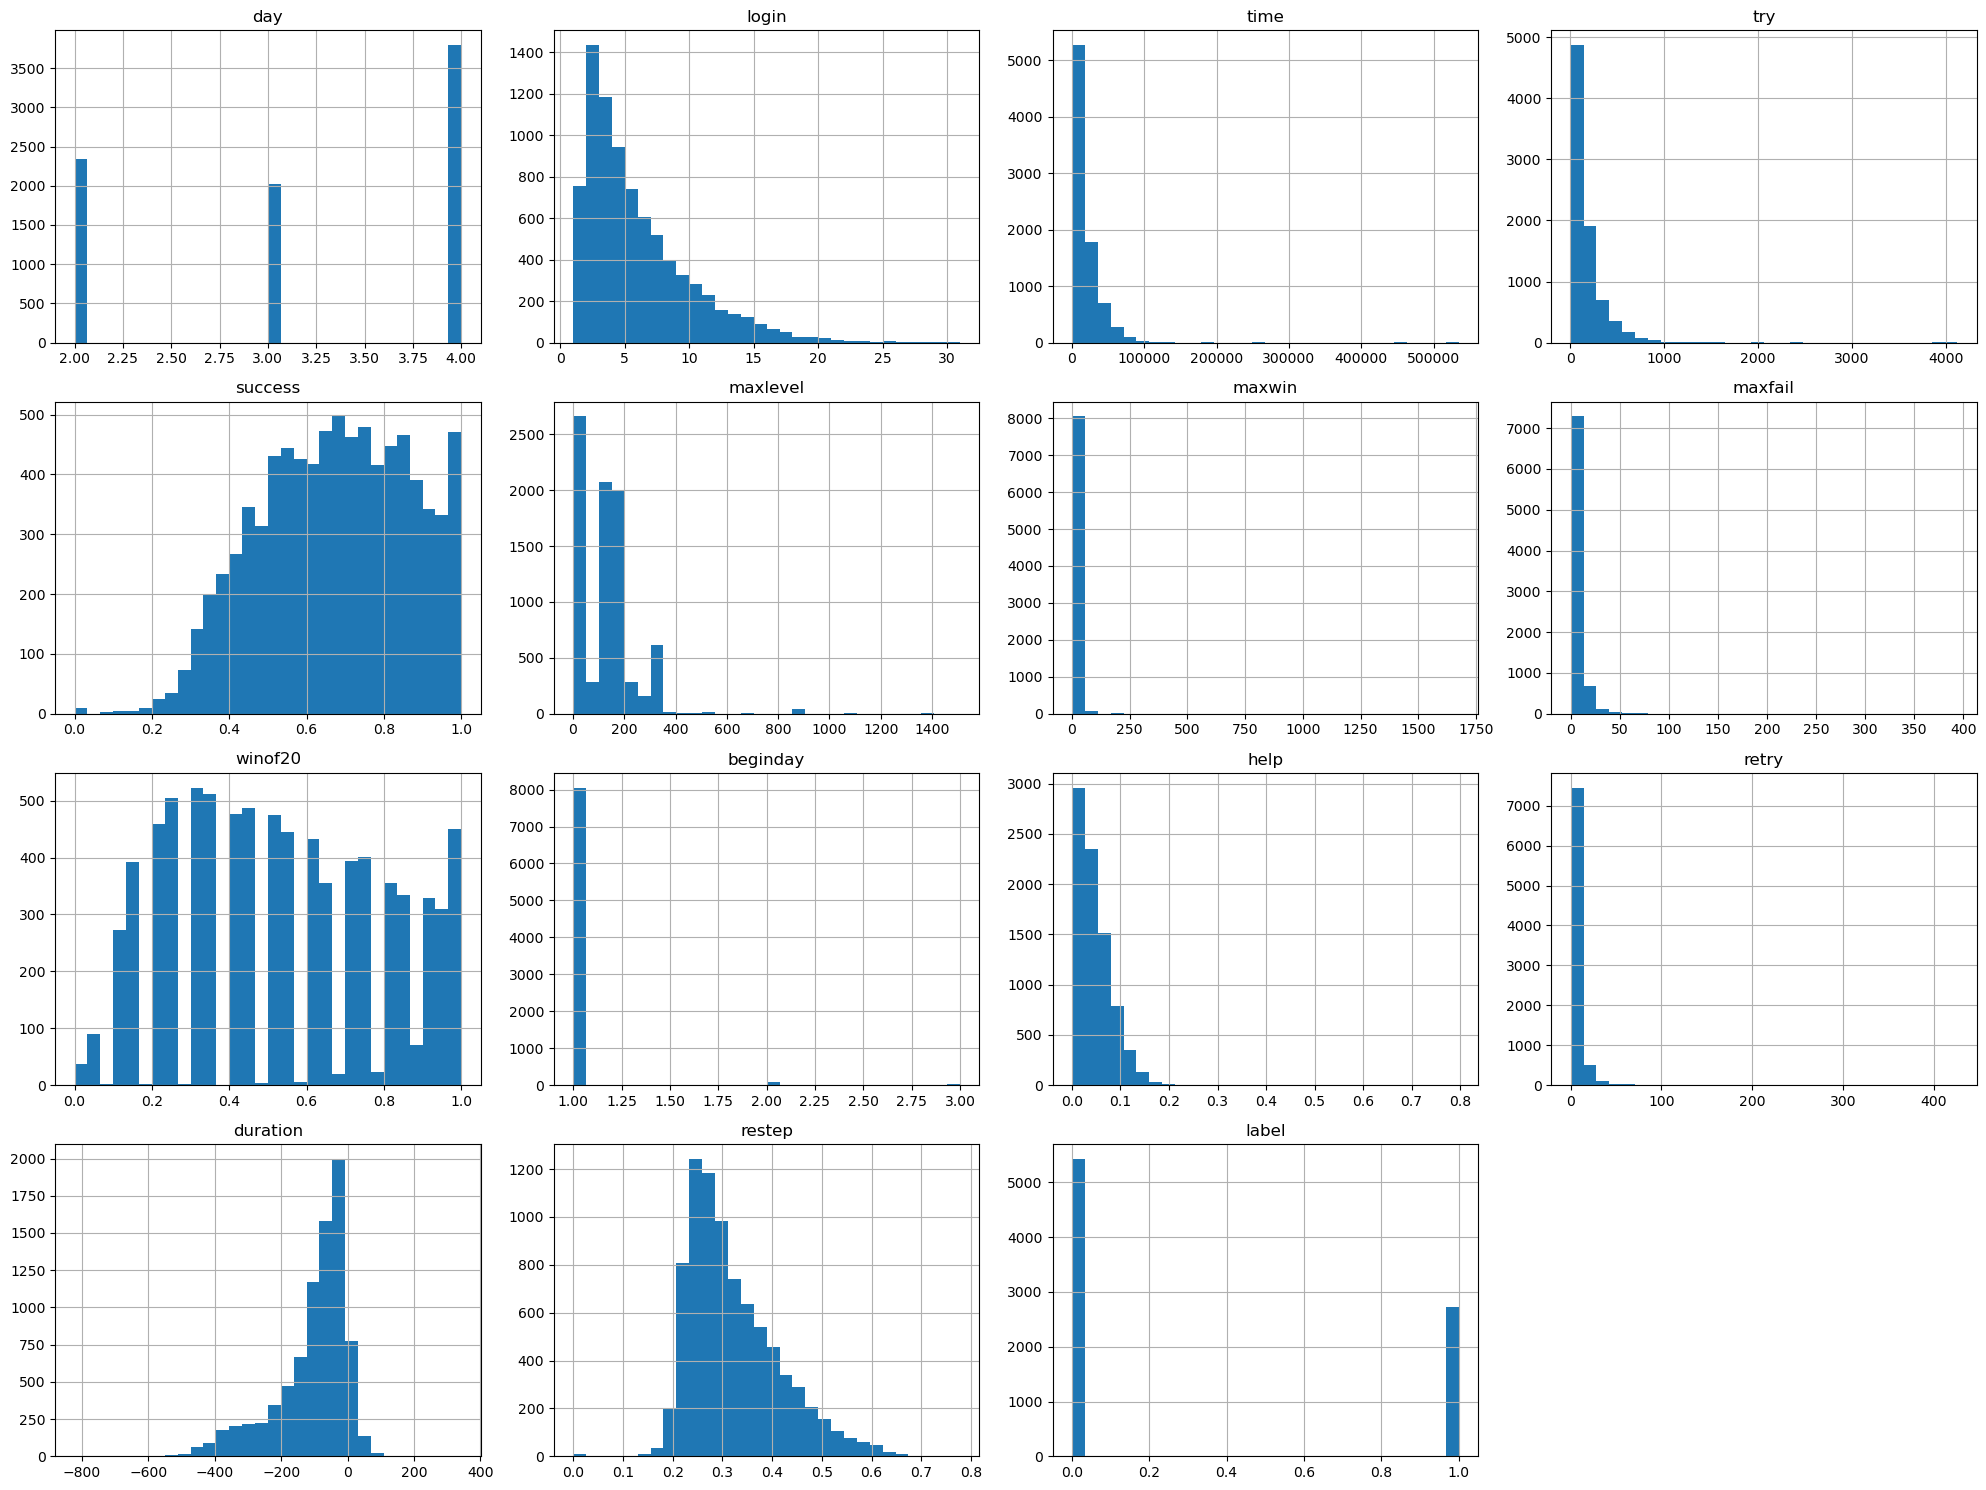

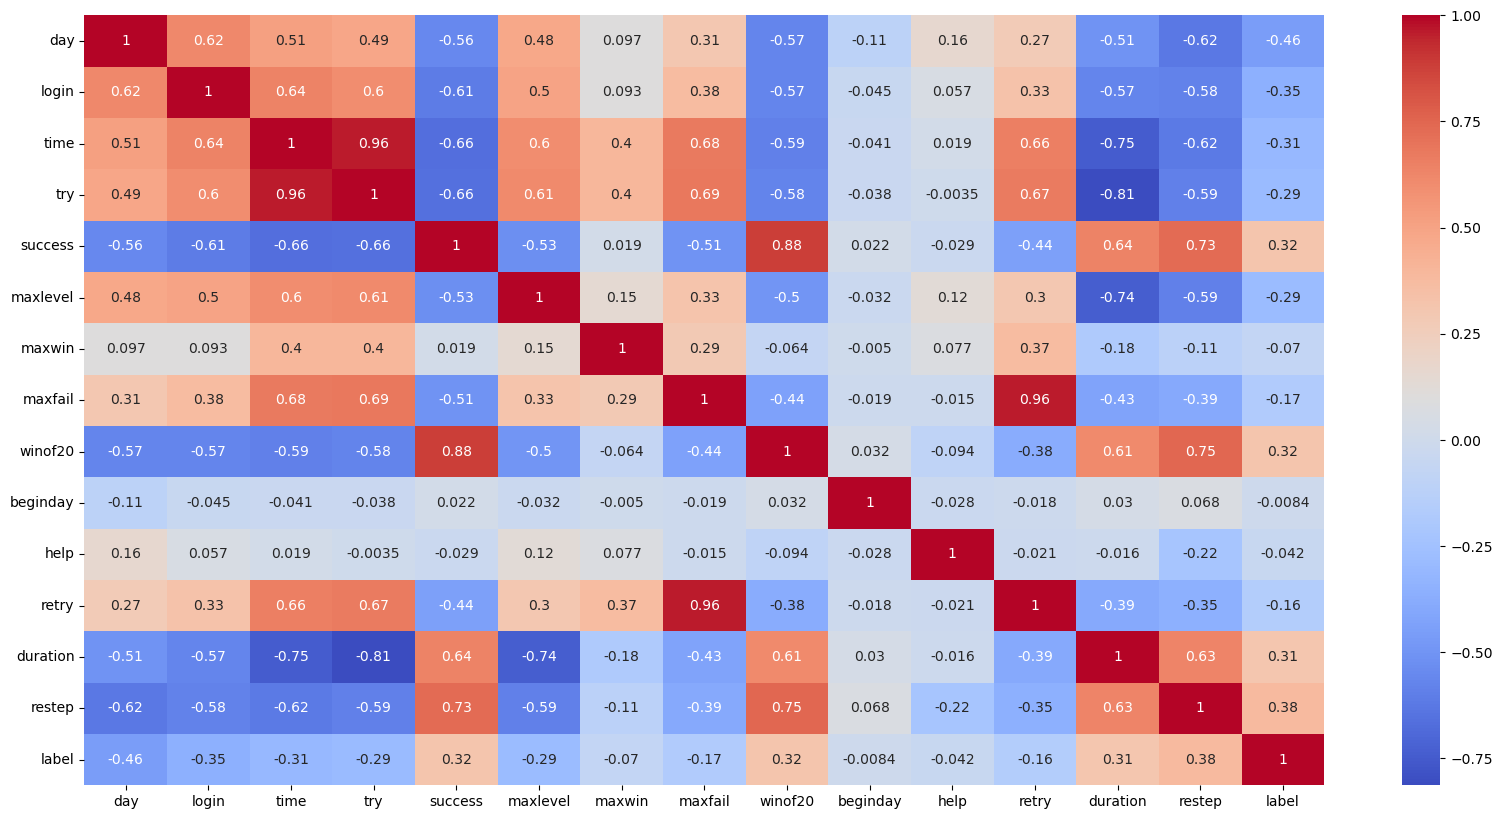

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设feature_df是你的DataFrame
feature_df = pd.DataFrame(np.concatenate((train_X, train_y),axis =1), columns=['day', 'login',  'time', 'try', 'success', 'maxlevel', 'maxwin', 'maxfail', 'winof20', 'beginday', 'help', 'retry', 'duration', 'restep', 'label'])

# 为所有特征绘制直方图
feature_df.hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()
 

# 计算特征间的相关性，并通过热图进行可视化
corr_matrix = feature_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


### 通过热力图分析，Label与success，winof20，duration和restep相关性较强。与day的相关性很弱，猜测有些用户是为了领取新手每日奖励才登陆游戏的，因此下面剔除【day】特征。

In [20]:
# 从训练集中删除day特征
train_X = np.delete(train_X, 0, axis=1)
valid_X = np.delete(valid_X, 0, axis=1)
test_X = np.delete(test_X, 0, axis=1)

# 数据归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_x = np.array(scaler.fit_transform(train_X))
valid_x = np.array(scaler.transform(valid_X))
test_x = np.array(scaler.transform(test_X))

## 模型搭建和训练

In [21]:

# 选择模型
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import calibration 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 定义模型和超参数空间
models = {
    'LinearSVM': calibration.CalibratedClassifierCV(svm.LinearSVC(loss='squared_hinge', dual=False)),
    'DecisionTree': tree.DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
    'MultBayes': MultinomialNB(),
    'Knn': KNeighborsClassifier()
}

params = {
    'LinearSVM': {
        'clf__base_estimator__C': [0.1, 1, 10],
        'clf__base_estimator__penalty': ['l1', 'l2']
    },
    'DecisionTree': {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [3, 5, 7]
    },
    'GaussianNB': {
        'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    'MultBayes': {
        'clf__alpha': [0.1, 1, 10],
        'clf__fit_prior': [True, False]
    },
    'Knn': {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    }
}


from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier


# 遍历每个分类器
for name, clf in models.items():
    # 使用 Bagging 进行训练和评估
    bcclf = BaggingClassifier(estimator=clf, n_estimators=50, max_samples=0.7,
                            max_features=0.7, bootstrap=True, bootstrap_features=True, n_jobs=1, random_state=1)
    bcclf.fit(train_x, train_y.flatten())
    pre = [x[1] for x in bcclf.predict_proba(valid_x)]
    fpr, tpr, thresholds = metrics.roc_curve(valid_y.flatten(), pre, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print("Bagging", name, auc)
    
    # 对于非 Knn 分类器，使用 AdaBoost 进行训练和评估，Knn本身就是一种集成学习思想的方法，不需要再使用AdaBoost
    if name!='Knn':
        adclf = AdaBoostClassifier(estimator=clf, n_estimators=30,learning_rate=1,algorithm='SAMME.R')
        adclf.fit(train_x, train_y.flatten())
        pre = [x[1] for x in adclf.predict_proba(valid_x)]
        fpr, tpr, thresholds = metrics.roc_curve(
            valid_y.flatten(), pre, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        print("Boosting", name, auc)
    print()


Bagging LinearSVM 0.757515995949609
Boosting LinearSVM 0.7496097740005572

Bagging DecisionTree 0.7409392081270605
Boosting DecisionTree 0.5956668016375911

Bagging GaussianNB 0.7409253109647977
Boosting GaussianNB 0.6927075272716018

Bagging MultBayes 0.7549557596473154
Boosting MultBayes 0.7399202934575317

Bagging Knn 0.7587853753844619

